# Spec Visualization

In [1]:
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import to_hex
from rich.progress import track

from htc.cameras.settings_cam import settings_cam
from htc.models.data.DataSpecification import DataSpecification
from htc.settings import settings
from htc.tivita.metadata import generate_metadata_table

In [2]:
# Parameter for papermill
# Spec visualizations can easily be created via
path = "data/pigs_semantic-only_5foldsV2.json"

In [3]:
path = Path(path)
specs = DataSpecification(path)
specs.activate_test_set()

sortings = {
    "weak_labels_validation_concept": ["train_partial", "validation", "train_weak", "test"],
    "pigs_semantic-only_5foldsV2": ["val_semantic_unknown", "train_semantic", "val_semantic_known", "test"],
}

if path.stem in sortings.keys():
    # Special sorting for this spec
    paths = []
    for name in sortings[path.stem]:
        for fold, splits in specs:
            for p in splits[name]:
                if p not in paths:
                    paths.append(p)
else:
    # Sorts by image_name
    paths = specs.paths()

image_names = [p.image_name() for p in paths]
dataset_names = ["none"] + specs.split_names()
folds = specs.fold_names()

# Fold splits
fold_matrix = np.zeros((len(folds), len(paths)), dtype=np.int64)
for fold, splits in track(specs):
    fold_name = folds.index(fold)

    for name, split_paths in splits.items():
        for p in split_paths:
            path_idx = image_names.index(p.image_name())
            fold_matrix[fold_name, path_idx] = dataset_names.index(name)

if np.all(fold_matrix > 0):
    dataset_names.remove("none")

# subject_name
pigs = sorted({p.subject_name for p in paths})
pig_matrix = np.zeros((1, len(paths)), dtype=np.int64)
for p in track(paths):
    path_idx = image_names.index(p.image_name())
    pig_matrix[0, path_idx] = pigs.index(p.subject_name)

# cam_name
df_meta = generate_metadata_table(paths)
cams = sorted(df_meta["camera_name"].unique())
cam_matrix = np.zeros((1, len(paths)), dtype=np.int64)
assert all(df_meta.query("image_name == @image_names") == df_meta)
for i, row in track(df_meta.iterrows(), total=len(df_meta)):
    path_idx = image_names.index(row["image_name"])
    cam_name = cams.index(row["camera_name"])
    cam_matrix[0, path_idx] = cam_name

# subject_name as ticks
pig_borders = []
pig_labels = []
last_subject_name = ""
for i, image_name in enumerate(image_names):
    subject_name = image_name.split("#")[0]
    if subject_name != last_subject_name:
        pig_borders.append(i)
        pig_labels.append(subject_name)
        last_subject_name = subject_name

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 506/506 [00:00<00:00, 28750.29it/s]


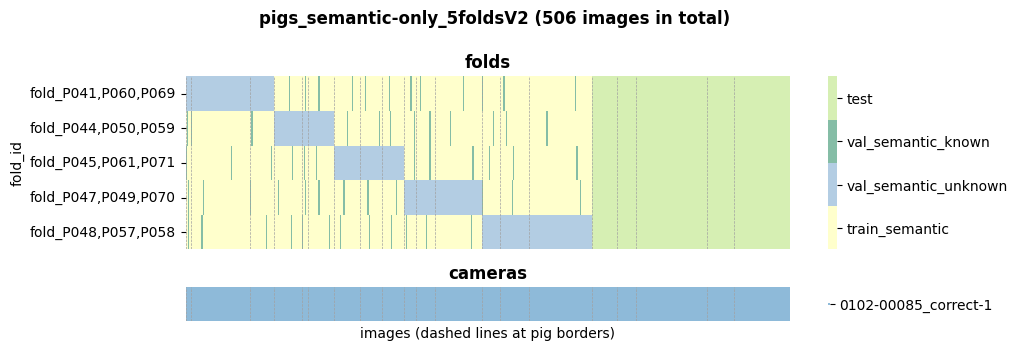

In [4]:
def set_cbar_ticks(ax, labels: list[str]) -> None:
    colorbar = ax.collections[0].colorbar
    r = colorbar.vmax - colorbar.vmin
    colorbar.set_ticks([colorbar.vmin + r / len(labels) * (0.5 + i) for i in range(len(labels))])
    colorbar.set_ticklabels(labels)


dataset_colors = ["#FFFFCC", "#B3CDE3", "#85BDA6", "#D6EFB3"]
if "none" in dataset_names:
    dataset_colors = ["#FFFFFF"] + dataset_colors
assert len(dataset_names) <= len(dataset_colors), "Not enough colors for the datasets available"
dataset_colors = dataset_colors[: len(dataset_names)]

pig_colors = []
for name in ["tab20b", "tab20c", "Set1", "Set2", "Set3", "Pastel1", "Pastel2", "Accent"]:
    pig_colors += [to_hex(c) for c in matplotlib.colormaps.get_cmap(name).colors]
assert len(pigs) <= len(pig_colors), "Not enough colors for the pigs available"
pig_colors = pig_colors[: len(pigs)]

fig, (ax1, ax2) = plt.subplots(
    2,
    1,
    tight_layout=True,
    figsize=(10, 0.8 * len(folds)),
    dpi=100,
    edgecolor="k",
    gridspec_kw={"height_ratios": [len(folds), 1]},
)

sns.heatmap(fold_matrix, cmap=dataset_colors, rasterized=True, ax=ax1)
sns.heatmap(cam_matrix, cmap=[settings_cam.camera_name_colors[c] for c in cams], alpha=0.5, rasterized=True, ax=ax2)

for ax in [ax1, ax2]:
    for b in pig_borders:
        ax.axvline(b, linewidth=0.5, color="#a1a1a1", linestyle="--")

ax1.set_ylabel("fold_name")
ax1.set_title("folds", fontweight="semibold")
ax1.set_xticks([])
ax1.set_yticklabels(folds, rotation=0)
set_cbar_ticks(ax1, dataset_names)

ax2.set_xlabel("images (dashed lines at pig borders)")
ax2.set_title("cameras", fontweight="semibold")
set_cbar_ticks(ax2, cams)
colorbar = ax2.collections[0].colorbar
colorbar.ax.set_aspect(6)
ax2.set_xticks([])
ax2.set_xticklabels([])
ax2.get_yaxis().set_visible(False)
fig.suptitle(f"{path.stem} ({len(image_names)} images in total)", fontweight="bold", y=0.99);

In [5]:
target_dir = settings.results_dir / "specs_figures"
target_dir.mkdir(exist_ok=True, parents=True)
fig.savefig(target_dir / f"{path.stem}.pdf")